Thus far my machine learning notebooks have focused on supervised learning problems - problems where we would like to predict the value of a target variable based on data points where we know the value of the target variable. 

Sometimes we can extract information from a dataset when we have no specific target variable in mind, we may simply wish to identify any natural groupings of the data. One of the names for this process is Clustering - the process of identifying clusters of data points where points within the same cluster are similar to each other.

The aim of this notebook is to use a dataset of NBA player statistics across the entire 2017-2018 regular season, that I scraped using my own Selenium web scraping tool, to see if we can find distinct clusters of players that are similar. See the introduction to my [NBA Data Visualisation](https://hexhamallstar.github.io/nbaviz.html) post for more details on how I obtained the data.

## This notebook contains the following content:
* [1. Data Cleaning & Exploration](#first-bullet)
* [2. The Clustering Algorithm](#second-bullet)
* [3. Visualising & Interpreting the Clusters](#third-bullet)
* [4. Conclusions & Improvements](#fourth-bullet)


## 1. Data Cleaning & Exploration <a class="anchor" id="first-bullet"></a>
As I have worked with this data set before, I know that there are some games in the dataset that we do not want to include when calculating a players aggregated statistics over the season.

In [1]:
#data manipulation tools
import pandas as pd
import numpy as np

#data plotting tools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from bokeh.plotting import figure, show, ColumnDataSource, output_file, save
from bokeh.io import output_notebook
from bokeh.models import HoverTool
output_notebook()

import backend 
# backend is the name of a .py file included with the webscraper that provides basic interaction with the database

Loading BokehJS ...

In [2]:
results_data = backend.retrieve_all_results() # command 'SELECT * from results'
results_data.sort_values(by = 'GameDate', inplace=True)
results_data.head()

,GameID,GameDate,HomeTeam,HomeScore,AwayTeam,AwayScore
1014,0021700002,2017-10-17 00:00:00,Houston Rockets,122,Golden State Warriors,121
1013,0021700001,2017-10-17 00:00:00,Boston Celtics,99,Cleveland Cavaliers,102
1003,0021700004,2017-10-18 00:00:00,Brooklyn Nets,131,Indiana Pacers,140
1004,0021700005,2017-10-18 00:00:00,Miami Heat,109,Orlando Magic,116
1005,0021700006,2017-10-18 00:00:00,Philadelphia 76ers,115,Washington Wizards,120


In [3]:
results_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1231 entries, 1014 to 1034
Data columns (total 6 columns):
GameID       1231 non-null object
GameDate     1231 non-null object
HomeTeam     1231 non-null object
HomeScore    1231 non-null object
AwayTeam     1231 non-null object
AwayScore    1231 non-null object
dtypes: object(6)
memory usage: 67.3+ KB


We can see that the results data has a unique ID number, a date, name and scores of the home and away teams. We have information for 1231 games, and all rows have information in i.e. no null values. Let's take a look at the teams that are present.

In [4]:
results_data['HomeTeam'].nunique()

32

Interestingly we get 32 unique home teams in the data. That seems strange because there are only 30 teams in the NBA. Let's see what teams are there.

In [5]:
results_data['HomeTeam'].unique()

array(['Houston Rockets', 'Boston Celtics', 'Brooklyn Nets', 'Miami Heat',
       'Philadelphia 76ers', 'Milwaukee Bucks', 'New Orleans Pelicans',
       'Charlotte Hornets', 'Denver Nuggets', 'Atlanta Hawks',
       'Portland Trail Blazers', 'Minnesota Timberwolves', 'LA Clippers',
       'New York Knicks', 'Chicago Bulls', 'Detroit Pistons',
       'Orlando Magic', 'Utah Jazz', 'Sacramento Kings',
       'Golden State Warriors', 'Los Angeles Lakers',
       'Cleveland Cavaliers', 'Indiana Pacers', 'San Antonio Spurs',
       'Phoenix Suns', 'Oklahoma City Thunder', 'Dallas Mavericks', ' ',
       'Memphis Grizzlies', 'Toronto Raptors', 'Washington Wizards',
       'Team LeBron'], dtype=object)

Notice that we get 'Team LeBron' and ' ' at the end. Team Lebron is the name of one of the teams from this years All-star game, and is therefore not a real team. Let's get the GameID of the games involving these teams:

In [6]:
#query the dataframe to show only rows that have the bad team names
results_data[(results_data['HomeTeam'] == 'Team LeBron') | (results_data['HomeTeam'] == ' ') ]
#save the ID's of the bad games in a list 
bad_games = list(results_data[(results_data['HomeTeam'] == 'Team LeBron') | (results_data['HomeTeam'] == ' ') ]['GameID'])

We can cross-reference this list of gameID's with the boxscore data we have gathered to see if we can get the correct team names from there.

In [7]:
boxscore_data = backend.retrieve_all_boxscores() # SQL statement 'SELECT * from boxscores'
boxscore_data.head()

,Player Name,Min,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,...,AST,TOV,STL,BLK,PF,PTS,+/-,Team,Starter,GameID
0,Bojan Bogdanovic,25:58,1,11,9.1,0,5,0.0,0,1,...,3,1,0,0,2,2,-13,Indiana Pacers,1,0021701005
1,Thaddeus Young,31:16,7,11,63.6,0,1,0.0,5,5,...,2,1,2,0,1,19,2,Indiana Pacers,1,0021701005
2,Myles Turner,30:12,9,12,75.0,2,4,50.0,5,6,...,0,2,1,0,5,25,13,Indiana Pacers,1,0021701005
3,Victor Oladipo,33:27,4,21,19.0,1,4,25.0,2,3,...,3,1,2,1,4,11,14,Indiana Pacers,1,0021701005
4,Cory Joseph,33:10,5,8,62.5,1,2,50.0,2,2,...,5,1,3,0,1,13,-1,Indiana Pacers,1,0021701005


We see that each row of the dataframe corresponds to the performance statistics of a single player for a team in a particular game specified by GameID. Let's check for completeness of the data.

In [8]:
boxscore_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31006 entries, 0 to 31005
Data columns (total 24 columns):
Player Name    31006 non-null object
Min            31006 non-null object
FGM            31006 non-null object
FGA            26140 non-null object
FG%            26140 non-null object
3PM            26140 non-null object
3PA            26140 non-null object
3P%            26140 non-null object
FTM            26140 non-null object
FTA            26140 non-null object
FT%            26140 non-null object
OREB           26140 non-null object
DREB           26140 non-null object
REB            26140 non-null object
AST            26140 non-null object
TOV            26140 non-null object
STL            26140 non-null object
BLK            26140 non-null object
PF             26140 non-null object
PTS            26140 non-null object
+/-            26140 non-null object
Team           31006 non-null object
Starter        31006 non-null int64
GameID         31006 non-null object
dtyp

We have 31006 individual entries, however only 26140 of these rows are complete, the others are missing data. It's also worth noting that currently all of the numerical stat columns are strings, not integers or floats. We will need to convert these later for calculations. Let's take a look at a missing row.

In [9]:
boxscore_data[pd.isnull(boxscore_data['FGA'])].head()

,Player Name,Min,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,...,AST,TOV,STL,BLK,PF,PTS,+/-,Team,Starter,GameID
11,TJ Leaf,,DNP - Coach's Decision,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,Indiana Pacers,0,0021701005
12,Joe Young,,DNP - Coach's Decision,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,Indiana Pacers,0,0021701005
22,Justin Anderson,,DNP - Coach's Decision,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,Philadelphia 76ers,0,0021701005
23,Richaun Holmes,,DNP - Coach's Decision,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,Philadelphia 76ers,0,0021701005
24,Timothe Luwawu-Cabarrot,,DNP - Coach's Decision,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,Philadelphia 76ers,0,0021701005


It looks like, even though these players did not play they still appear in the boxscore for the team. The 'Min' column has an empty string in it and every stat column except 'FGM' is empty. The 'FGM' column contains the reasons for a player not playing.

In [10]:
boxscore_data[pd.isnull(boxscore_data['FGA'])]['FGM'].unique()

array(["DNP - Coach's Decision                  ",
       'DNP - Injury/Illness                    ',
       'DND - Injury/Illness                    ',
       'NWT - Injury/Illness                    ',
       'DND - Rest                              ',
       'NWT - Personal                          ',
       'NWT - Suspended                         ',
       'NWT - Trade Pending                     ',
       'NWT - Rest                              ',
       'Inactive - Injury/Illness               ',
       'DND_COACH                               '], dtype=object)

We can see that there are various possibilities for the reason a player didn't play.

It turns out that in the listof bad games, only the Allstar game is an invalid game and the rest were actual regular season games. The player statistics were intact, just the team names were missing. Because we are aggregating stats by player name, we just need to remove the Allstar game which is GameID 0031700001.

We will also remove any row where the player did not play to reduce computation and avoid issues with trying to aggregate with empty cells in a row/column. 

In [11]:
boxscore_data=boxscore_data[boxscore_data['GameID'] != '0031700001']
boxscore_data=boxscore_data[boxscore_data['Min'] != '']
boxscore_data.head()

,Player Name,Min,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,...,AST,TOV,STL,BLK,PF,PTS,+/-,Team,Starter,GameID
0,Bojan Bogdanovic,25:58,1,11,9.1,0,5,0.0,0,1,...,3,1,0,0,2,2,-13,Indiana Pacers,1,0021701005
1,Thaddeus Young,31:16,7,11,63.6,0,1,0.0,5,5,...,2,1,2,0,1,19,2,Indiana Pacers,1,0021701005
2,Myles Turner,30:12,9,12,75.0,2,4,50.0,5,6,...,0,2,1,0,5,25,13,Indiana Pacers,1,0021701005
3,Victor Oladipo,33:27,4,21,19.0,1,4,25.0,2,3,...,3,1,2,1,4,11,14,Indiana Pacers,1,0021701005
4,Cory Joseph,33:10,5,8,62.5,1,2,50.0,2,2,...,5,1,3,0,1,13,-1,Indiana Pacers,1,0021701005


We can remove the columns Team, Starter and GameID now as we will be grouping by Player Name and averaging the statistics to get a per-game average for each. All of the statistic columns can be safely converted to floating point numbers directly except the Min column.

We will also remove the Percentage columns as they cannot be averaged. 

Minutes are given in the format 'mm:ss' so we need to split the string by the ':' symbol and convert to a decimal number.

In [12]:
boxscore_data['Min'] = boxscore_data['Min'].apply(lambda x: float(x.split(':')[0]) + float(x.split(':')[1])/60.)

In [13]:
boxscore_data = boxscore_data.drop(['Team','Starter','GameID', 'FG%','3P%','FT%'], axis=1)
#also need to remove rows where the player played no minutes
boxscore_data = boxscore_data[boxscore_data['Min'] != 0]

#create a list to easily iterate over columns
column_list = list(boxscore_data)
column_list.remove('Player Name')
column_list.remove('Min')

#convert each column in the list to floating point numbers
for col in column_list:
    boxscore_data[col] = boxscore_data[col].apply(lambda x: float(x))
    
boxscore_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26099 entries, 0 to 31002
Data columns (total 18 columns):
Player Name    26099 non-null object
Min            26099 non-null float64
FGM            26099 non-null float64
FGA            26099 non-null float64
3PM            26099 non-null float64
3PA            26099 non-null float64
FTM            26099 non-null float64
FTA            26099 non-null float64
OREB           26099 non-null float64
DREB           26099 non-null float64
REB            26099 non-null float64
AST            26099 non-null float64
TOV            26099 non-null float64
STL            26099 non-null float64
BLK            26099 non-null float64
PF             26099 non-null float64
PTS            26099 non-null float64
+/-            26099 non-null float64
dtypes: float64(17), object(1)
memory usage: 3.8+ MB


Now we can calculate each players total for each stat, the average over the whole season and the standard deviation. We will also count the number of games played incase we want to filter out players that only played a few games from our stats.

In [14]:
#calculating stat totals
player_totals = boxscore_data.groupby(by='Player Name', as_index=False).sum()
player_totals.reset_index(drop=True, inplace=True)
player_totals.head()

,Player Name,Min,FGM,FGA,3PM,3PA,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,PF,PTS,+/-
0,Aaron Brooks,189.433333,28.0,69.0,11.0,31.0,8.0,11.0,7.0,10.0,17.0,20.0,11.0,6.0,0.0,28.0,75.0,-75.0
1,Aaron Gordon,1908.850000,375.0,865.0,115.0,342.0,157.0,225.0,87.0,370.0,457.0,136.0,107.0,59.0,45.0,111.0,1022.0,-92.0
2,Aaron Harrison,233.250000,19.0,69.0,9.0,43.0,13.0,17.0,4.0,20.0,24.0,11.0,3.0,9.0,2.0,27.0,60.0,-72.0
3,Aaron Jackson,34.500000,3.0,9.0,1.0,4.0,1.0,2.0,2.0,1.0,3.0,1.0,1.0,0.0,0.0,4.0,8.0,-10.0
4,Abdel Nader,521.550000,50.0,149.0,23.0,65.0,23.0,39.0,13.0,58.0,71.0,26.0,34.0,15.0,10.0,45.0,146.0,-108.0


In [15]:
#calculating stat averages
player_averages = boxscore_data.groupby(by='Player Name', as_index=False).mean()
player_averages.reset_index(drop=True, inplace=True)
player_averages.head()

,Player Name,Min,FGM,FGA,3PM,3PA,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,PF,PTS,+/-
0,Aaron Brooks,5.919792,0.875000,2.156250,0.343750,0.968750,0.250000,0.343750,0.218750,0.312500,0.531250,0.625000,0.343750,0.187500,0.000000,0.875000,2.343750,-2.343750
1,Aaron Gordon,32.911207,6.465517,14.913793,1.982759,5.896552,2.706897,3.879310,1.500000,6.379310,7.879310,2.344828,1.844828,1.017241,0.775862,1.913793,17.620690,-1.586207
2,Aaron Harrison,25.916667,2.111111,7.666667,1.000000,4.777778,1.444444,1.888889,0.444444,2.222222,2.666667,1.222222,0.333333,1.000000,0.222222,3.000000,6.666667,-8.000000
3,Aaron Jackson,34.500000,3.000000,9.000000,1.000000,4.000000,1.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,4.000000,8.000000,-10.000000
4,Abdel Nader,10.865625,1.041667,3.104167,0.479167,1.354167,0.479167,0.812500,0.270833,1.208333,1.479167,0.541667,0.708333,0.312500,0.208333,0.937500,3.041667,-2.250000


In [16]:
#calculating stat standard deviation
player_dev = boxscore_data.groupby(by='Player Name').std().reset_index()
player_dev.reset_index(drop=True, inplace=True)
player_dev.head()

,Player Name,Min,FGM,FGA,3PM,3PA,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,PF,PTS,+/-
0,Aaron Brooks,6.194794,1.039541,2.628742,0.601577,1.379209,0.622171,0.827331,0.490844,0.470929,0.761339,0.751343,0.601577,0.396558,0.000000,1.288911,2.835368,6.141395
1,Aaron Gordon,5.653894,2.915268,4.374104,1.382743,2.322201,2.301858,3.084071,1.246046,2.814920,3.293149,1.649580,1.460614,1.034347,0.838610,1.354453,7.543622,12.587984
2,Aaron Harrison,11.445723,1.833333,4.330127,1.118034,2.438123,1.509231,2.147350,0.726483,1.715938,1.802776,1.301708,0.500000,1.000000,0.440959,1.224745,5.315073,9.772410
3,Aaron Jackson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Abdel Nader,8.326825,1.166160,2.998153,0.683843,1.494523,1.110675,1.645836,0.706793,1.529265,1.989222,0.797825,0.849489,0.551834,0.503534,1.174304,3.148511,7.763800


In [17]:
#player game counts
game_counts = boxscore_data.groupby(by='Player Name', as_index=False).count()
game_counts.reset_index(drop=True, inplace=True)
#only need to keep one column as they are all the same
game_counts= game_counts[['Player Name','Min']]
game_counts.rename(columns = {'Min':'GP'}, inplace = True)
game_counts.head()

,Player Name,GP
0,Aaron Brooks,32
1,Aaron Gordon,58
2,Aaron Harrison,9
3,Aaron Jackson,1
4,Abdel Nader,48


In [18]:
#Remove all players with less than 5 games
player_averages = player_averages[game_counts['GP'] >= 5]
player_dev = player_dev[game_counts['GP'] >= 5]

Now we can take a look at some statistics that might be of interest. Firstly let's see how the per-game averages of each stat are distributed.

Text(0.5,1.01,'Distribution of player average stats per game for the 2017/2018 season')

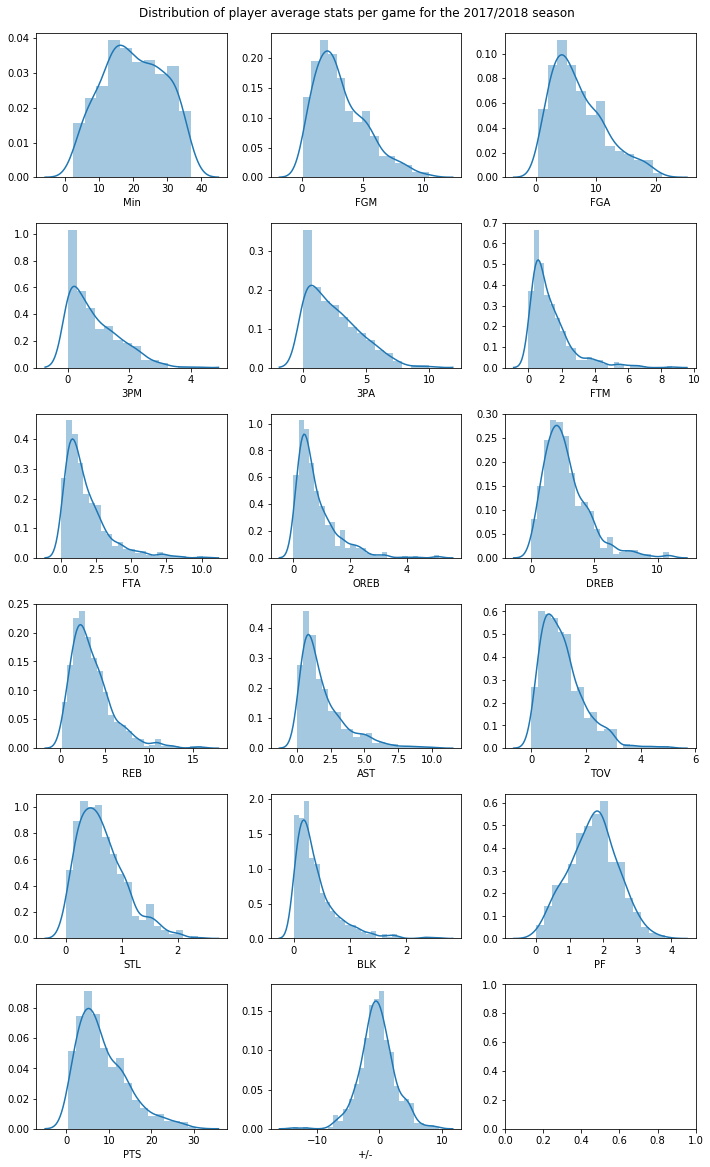

In [19]:
fig, axes = plt.subplots((len(player_averages.columns)-1)//3 + 1, 3, figsize=(10, 16))
for col,axis in zip(player_averages.columns.tolist()[1:],axes.flatten()):
    sns.distplot(player_averages[col], ax=axis)
plt.tight_layout()
plt.suptitle('Distribution of player average stats per game for the 2017/2018 season', y=1.01)

We can see that, generally speaking, the minutes played, personal fouls and +/- are roughly normally distributed about their respective means. All of the other statistics are right-skewed indicating that there are some players with far higher averages than the overall league average (in some cases such as points scored these are superstar players, in other cases like turnovers this could be inexperienced/bad players).

Let's take a look at the highest values of some of the stats.

In [20]:
print('The players with the highest points per game are:')
print(player_averages.sort_values(by='PTS', ascending=False)[['Player Name', 'PTS']].head(5))

The players with the highest points per game are:
               Player Name        PTS
218           James Harden  30.430556
29           Anthony Davis  28.133333
325           LeBron James  27.451220
87          Damian Lillard  26.876712
174  Giannis Antetokounmpo  26.853333


These results can be easily compared with the Official NBA website to check validity of the calculations. We can see that the results match so the we can have confidence in the completeness of the dataset.

<img src='images/PPG_check.png' style="max-width:80%;">

In [21]:
print('The players with the highest blocks per game are:')
print(player_averages.sort_values(by='BLK', ascending=False)[['Player Name', 'BLK']].head(5))

The players with the highest blocks per game are:
            Player Name       BLK
29        Anthony Davis  2.573333
309  Kristaps Porzingis  2.395833
444         Rudy Gobert  2.303571
75         Clint Capela  1.851351
385        Myles Turner  1.830769


In [22]:
print('The players with the lowest +/- per game are:')
print(player_averages.sort_values(by='+/-', ascending=True)[['Player Name', '+/-']].head(5))

The players with the lowest +/- per game are:
             Player Name        +/-
271            Josh Gray -13.800000
532  Xavier Rathan-Mayes -11.800000
2         Aaron Harrison  -8.000000
150        Elfrid Payton  -7.285714
536          Zach LaVine  -7.166667


We would expect the lowest +/- from players that are playing on teams that consistently lose. The teams for these 5 players are Phoenix Suns, Memphis Grizzlies, Dallas Mavericks, Phoenix Suns and Chicago Bulls respectively. These teams were very poor this season, which explains the low +/- even for reasonably good players like Payton and LaVine. Also of interest is which players are the most/least consistent performers:

In [23]:
print('The most consistent scorers are:')
print(player_dev[player_dev['PTS'] > 0].sort_values(by='PTS', ascending=True)[['Player Name', 'PTS']].head(5))

The most consistent scorers are:
          Player Name       PTS
515       Vander Blue  0.894427
386      Nate Wolters  0.894427
514     Udonis Haslem  1.016350
77       Cole Aldrich  1.075706
326  London Perrantes  1.160239


In [24]:
print('The least consistent scorers are:')
print(player_dev[player_dev['PTS'] > 0].sort_values(by='PTS', ascending=False)[['Player Name', 'PTS']].head(5))

The least consistent scorers are:
           Player Name       PTS
29       Anthony Davis  9.556847
127       Devin Booker  9.330956
218       James Harden  9.167958
112      DeMar DeRozan  9.084693
445  Russell Westbrook  8.728101


Notice that some of our top scorers appear in the category of least consistent. Players that score more points on average have a higher range of possible points scored than players that score few points per game.

In [25]:
source = ColumnDataSource(ColumnDataSource.from_df(player_averages))

p=figure(title='Points per game vs. Minutes per game for the 2017/2018 regular season',
        tools="pan,box_zoom,reset,save,hover")

hover = p.select(dict(type=HoverTool))

hover.tooltips = [('MPG','@Min{0, 0.0}'), ('PPG','@PTS{0, 0.0}'), ('Name','@{Player Name}')]

p.circle('Min', 'PTS', size=6,  source = source)

p.yaxis.axis_label = 'Points per game'
p.xaxis.axis_label = 'Minutes per game'
p.title.align = 'center'

show(p)

The data points in the above graph will display a tooltip when the mouse is hovered over them that displays the co-ordinates of the datapoint along with the name of the relevant player. 

The general trend (which is intuitive for most statistics) is that more minutes played means more points. A trend can be clearly distinguished in the plot, although a few players that stand out from the norm. For example, at 10 MPG Jonathan Gibson (Boston Celtics) stands out with 8.5 PPG which is significantly higher than the other players with around the same MPG. Conversely at 26.6 MPG Andre Roberson (Oklahoma City Thunder) scores only 5.0 PPG, but he is a very important defensive player hence why he still get's quite a lot of minutes.

In [26]:
p=figure(title='Average +/- vs. Minutes per game for the 2017/2018 regular season',
        tools="pan,box_zoom,reset,save,hover")

hover = p.select(dict(type=HoverTool))

hover.tooltips = [('MPG','@Min{0, 0.0}'), ('+/-','@{+/-}{0, 0.0}'), ('Name','@{Player Name}')]

p.circle('Min', '+/-', size=6,  source = source)

p.yaxis.axis_label = 'Average +/-'
p.xaxis.axis_label = 'Minutes per game'
p.title.align = 'center'

show(p)

The nature of the +/- stat means that if you sum it over the entire league you should get zero. We can see that the +/- seems to be independent of minutes played, which makes sense because there will be players that play lots of minutes for teams the lose a lot as well as players that play lots of minutes for teams that win a lot. 

We have already looked at the extreme points at the bottom of the +/- scale. There's a cluster of points in the top right that includes Stephen Curry (Golden State Warriors), Eric Gordon (Houston Rockets) and Chris Paul (Houston Rockets) who have the largest +/- averages. These were the top 2 teams in the Western Conference so it makes sense that their players would generally be on the court when more points are being scored than conceded.

To reduce the effect of the stats dependence on the number of minutes played per game we can divide each players rows by the minutes per game. This will give us stats per minute played which is a more accurate representation of players ability. We can also keep the minutes played per game and games played as columns to separate players that play very little vs. players that play a lot.

In [27]:
per_min_stats = player_averages.drop(['Player Name','Min'],  axis=1)
per_min_stats = per_min_stats.divide(player_averages['Min'], axis=0)
per_min_stats['Min'] = player_averages['Min']
per_min_stats['Player Name'] = player_averages['Player Name']
per_min_stats = pd.merge(per_min_stats, game_counts, how='left', on='Player Name')
cols = per_min_stats.columns.tolist()
cols = cols[-2:-1] + cols[:-2] + cols[-1:]
per_min_stats = per_min_stats[cols]
per_min_stats.head()

,Player Name,FGM,FGA,3PM,3PA,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,PF,PTS,+/-,Min,GP
0,Aaron Brooks,0.147809,0.364244,0.058068,0.163646,0.042231,0.058068,0.036952,0.052789,0.089741,0.105578,0.058068,0.031673,0.000000,0.147809,0.395918,-0.395918,5.919792,32
1,Aaron Gordon,0.196453,0.453152,0.060246,0.179165,0.082248,0.117872,0.045577,0.193834,0.239411,0.071247,0.056055,0.030909,0.023574,0.058150,0.535401,-0.048197,32.911207,58
2,Aaron Harrison,0.081458,0.295820,0.038585,0.184352,0.055734,0.072883,0.017149,0.085745,0.102894,0.047160,0.012862,0.038585,0.008574,0.115756,0.257235,-0.308682,25.916667,9
3,Abdel Nader,0.095868,0.285687,0.044099,0.124629,0.044099,0.074777,0.024926,0.111207,0.136133,0.049851,0.065190,0.028760,0.019174,0.086281,0.279935,-0.207075,10.865625,48
4,Adreian Payne,0.164512,0.235018,0.047004,0.070505,0.117509,0.141011,0.047004,0.164512,0.211516,0.000000,0.047004,0.047004,0.000000,0.141011,0.493537,-0.305523,8.510000,5


Text(0.5,1.01,'Distribution of player average stats per minute played for the 2017/2018 season')

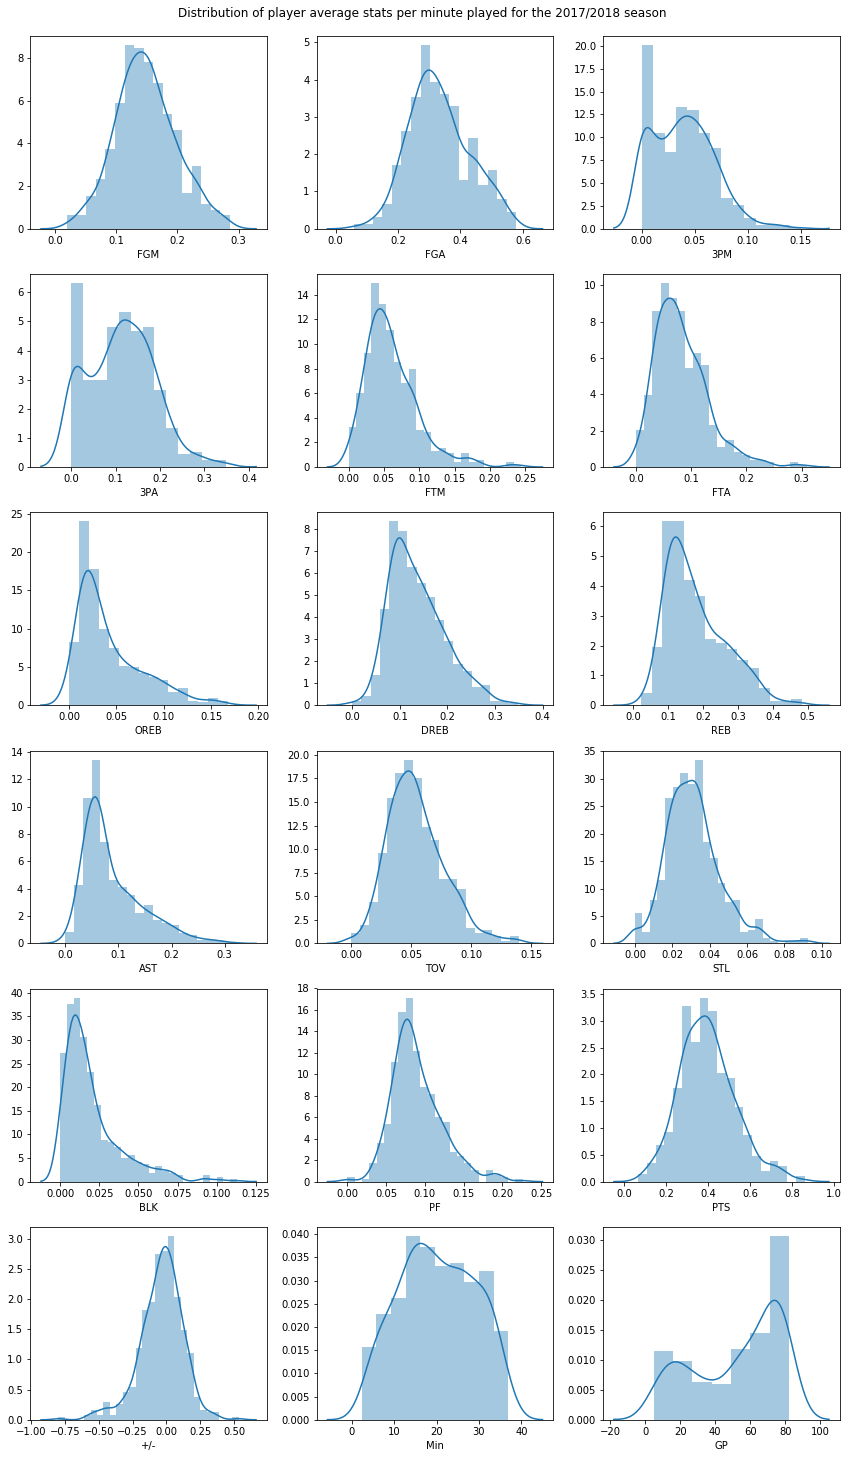

In [28]:
fig, axes = plt.subplots((len(per_min_stats.columns)-1)//3, 3, figsize=(12, 20))
for col,axis in zip(per_min_stats.columns.tolist()[1:],axes.flatten()):
    sns.distplot(per_min_stats[col], ax=axis)
plt.tight_layout()
plt.suptitle('Distribution of player average stats per minute played for the 2017/2018 season', y=1.01)

We can see that this has reduced the level of skew in some of the statistics. Now we can move on to the Clustering process.

## 2. The Clustering Algorithm <a class="anchor" id="second-bullet"></a>

One of the most common clustering algorithms in use is **k-means**. The process for finding the k clusters that best fit the dataset using **k-means** is as follows:

1. **Initialize the Cluster centers**: A smart way to do this is to select a datapoint from our set at random, then for each remaining center to be initialized we pick another datapoint but this time the probability of picking a point is proportional to it's distance from the existing centers. This gives the centers a good chance of being well separated and reduces the probability of finding local optimum positions rather than global optimum positions.
2. **Assign each data point to the nearest Cluster center**: Using a distance metric, calculate the distance from each data point to each cluster center and 'assign' each data point to the nearest center.
3. **Calculate the central co-ordinates of each Cluster**: Take the average value in each feature direction for each Cluster, this is where we would like our Cluster center to move to.
4. **Move the Cluster centers**: Move the Cluster centers to the locations calculated in Step 3. 
5. **Repeat until convergence**: Repeat Steps 2 to 4 until datapoint Cluster assignments no longer change.

The distance metric most commonly used with k-means is the **Euclidean distance** also known as the **L2 norm** of the difference between 2 vectors. The distance between 2 points $q$ and $p$, both having n features, is defined as:

$$\sqrt{\sum_{i=1}^{n}{(q_{i} - p_{i})^{2}}}$$

First things first, we need to scale our data. If we have data in different dimensions with different ranges then dimensions with a large numerical range will have the largest influence on cluster positions. Clustering with k-means treats each dimension equally, so for example we do not want a 0.1 point increase in points scored per minute (fairly insignificant) to be treated the same as a 0.1 block increase in blocks per minute (extremely significant, considering the highest possible value is between 0.1 and 0.125 blocks per minute). 

At the same time we can log-transform all of our data. This has the effect of centring the distribution of each feature. We will first take logs and replot our distributions.

Text(0.5,1.01,'Reduced-skew distributions of player average stats for the 2017/2018 season')

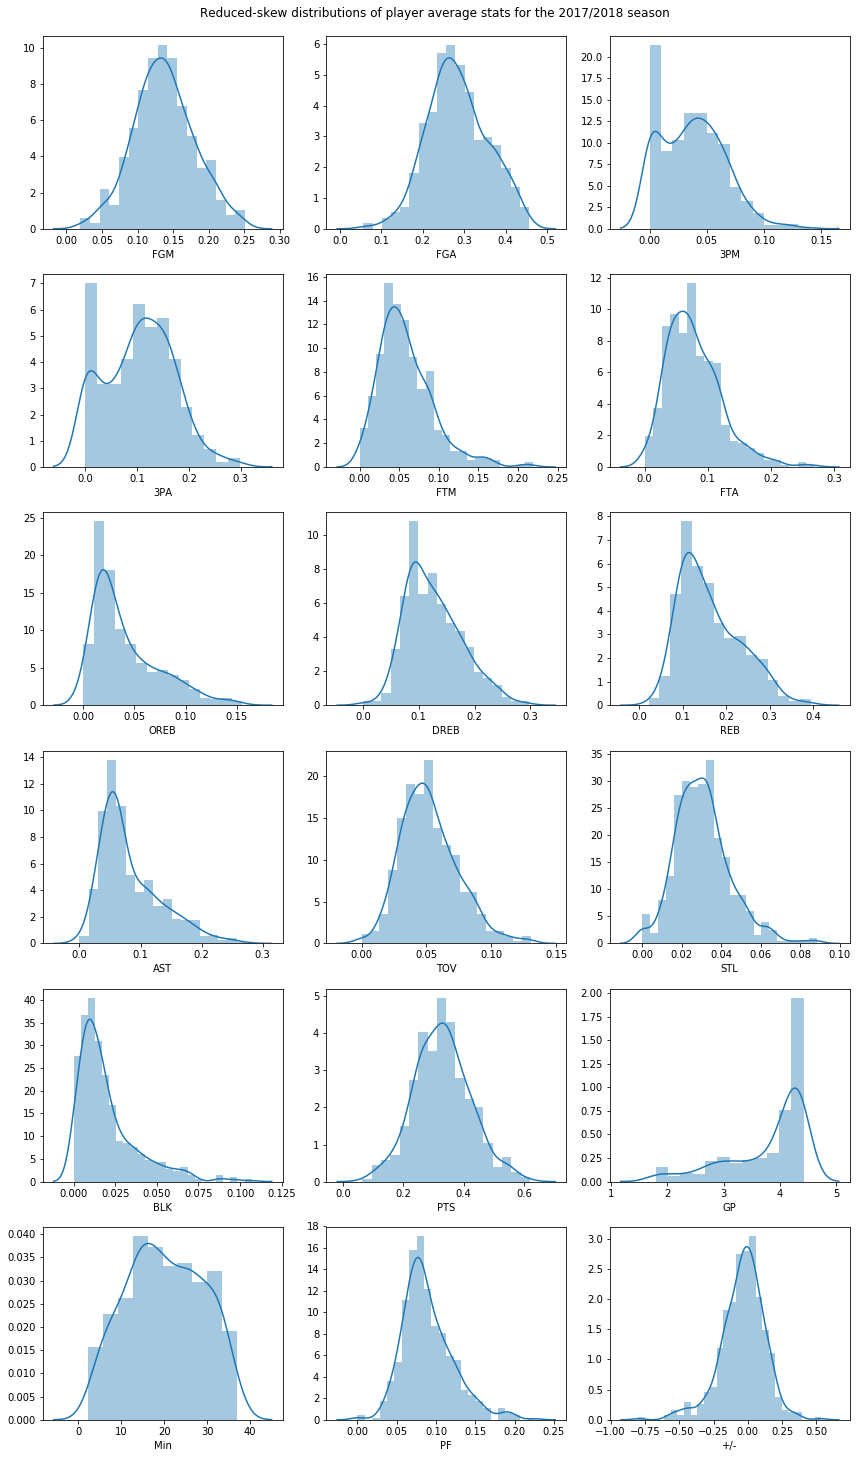

In [29]:
#not log-transforming data that is already normally distributed
cluster_data = per_min_stats.drop(['Player Name','Min','PF','+/-'], axis=1)
#add 1 to every stat to make sure we don't try to take log of 0
#this has the effect of making zero's map back to zero
cluster_data = cluster_data + 1
cluster_data = np.log(cluster_data)
cluster_data[['Min','PF','+/-']] = per_min_stats[['Min','PF','+/-']]

fig, axes = plt.subplots((len(cluster_data.columns)-1)//3 + 1, 3, figsize=(12, 20))
for col,axis in zip(cluster_data.columns.tolist(),axes.flatten()):
    sns.distplot(cluster_data[col], ax=axis)
plt.tight_layout()
plt.suptitle('Reduced-skew distributions of player average stats for the 2017/2018 season', y=1.01)

Now we scale the data to have mean 0 and variance 1 using the sklearn StandardScaler tool.

In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [31]:
scaled_data = pd.DataFrame(scaler.fit_transform(cluster_data), columns = cluster_data.columns)
scaled_data.head()

,FGM,FGA,3PM,3PA,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,PTS,GP,Min,PF,+/-
0,0.011303,0.361510,0.684921,0.706275,-0.497433,-0.498728,-0.147110,-1.504115,-1.091970,0.352943,0.189149,0.045639,-1.104112,0.043681,-0.422849,-1.620503,1.798227,-2.229478
1,0.981608,1.233884,0.759740,0.906056,0.590152,0.777002,0.109651,1.006071,0.750370,-0.279934,0.102250,-0.007323,0.194460,1.064857,0.404913,1.447093,-0.974254,-0.069096
2,-1.380697,-0.349505,0.008645,0.972230,-0.125851,-0.176096,-0.744828,-0.888714,-0.920226,-0.736203,-1.803153,0.522535,-0.628287,-1.078260,-2.123767,0.652158,0.807049,-1.687483
3,-1.071253,-0.457981,0.201327,0.191995,-0.445740,-0.135173,-0.508730,-0.425907,-0.495163,-0.684698,0.495259,-0.156307,-0.045667,-0.886392,0.140331,-1.058405,-0.104371,-1.056204
4,0.349040,-1.013561,0.302402,-0.551739,1.515630,1.252362,0.151909,0.509581,0.424493,-1.660726,-0.290494,1.099108,-1.104112,0.768449,-2.851512,-1.326123,1.587995,-1.667858


Defining a function to generate initial cluster centers. We will use an algorithm called [**kmeans++**](https://en.wikipedia.org/wiki/K-means%2B%2B) that chooses initial centers from the datapoints. The probability of choosing a data point scales with its distance from the already chosen centers, causing the centers to be likely to be spread out.

In [32]:
#import pairwise distances so we can calculate distance between points
from sklearn.metrics import pairwise_distances

def initialize_kmeans(data, k):
    '''Takes in a numpy array of the dataset and an integer of the desired number of clusters. 
    Returns the indices of the points to be used as initial centers'''
    
    n_points = data.shape[0]
    
    #empty array to contain the centers
    centroids = np.zeros((k,data.shape[1]))
    
    #first centroid is an equal probability random choice
    idx = np.random.randint(n_points)
    centroids[0, :] = data[idx,:]
    
    # Compute distances from the first centroid chosen to all the other data points
    squared_distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()**2
    
    for i in range(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughtly speaking, a new centroid should be as far as from ohter centroids as possible.
        idx = np.random.choice(n_points, 1, p=squared_distances/sum(squared_distances))
        centroids[i, :] = data[idx,:]
        # Now compute distances from the centroids to all data points
        squared_distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean')**2,axis=1)
    
    return centroids

In [33]:
centroids = initialize_kmeans(scaled_data.as_matrix(), 3)
print(centroids.shape)

(3, 18)


We can see that we have successfully chosen 3 data points from the dataframe to act as our initial centroids. Now we can write a function that assigns each row of the dataframe to one of the 3 clusters.

In [34]:
def assign_clusters(data, centroids):
    
    # Compute distances between each data point and the set of centroids:
    distances_from_centroids = pairwise_distances(data, centroids, metric='euclidean')
    
    # Compute cluster assignments for each data point:
    cluster_assignment = []
    for distance in distances_from_centroids:
        #add to the list the index of the minimum distance
        cluster_assignment.append(np.argmin(distance))
    
    return np.array(cluster_assignment)

In [35]:
assignments = assign_clusters(scaled_data.as_matrix(), centroids)
print(assignments)

[2 1 2 0 0 0 0 0 0 1 2 2 0 0 0 2 1 0 0 0 0 0 1 2 1 0 0 1 1 0 0 0 1 1 0 0 1
 0 1 0 2 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 2 0 1 1 1 0 1 0 2 0 0 1 0 0 0 0 1
 1 0 1 1 0 0 0 1 0 1 0 2 0 1 0 0 1 0 1 1 2 1 0 0 0 0 2 1 0 0 0 1 1 1 0 1 0
 1 1 1 0 0 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0 0
 1 0 1 1 1 1 2 1 1 0 1 0 0 2 2 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 1 0 0 1
 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 2 2 0 0 0 1 0 2 0 1 0 1 1 1 0
 0 1 1 1 1 0 1 1 1 0 1 0 1 0 0 0 2 1 0 0 0 0 0 0 1 0 1 1 0 1 2 0 0 1 1 1 1
 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0
 0 0 1 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 2
 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 2 2 0 2 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0
 0 0 0 0 0 0 2 0 0 1 0 1 0 0 0 0 1 2 1 1 2 1 1 1 1 0 0 1 1 0 1 0 1 2 0 0 0
 0 1 0 2 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0
 1 0 1 1 1 0 0 1 0 0 2 0 1 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 1 0 2 1 0 2 1 1 1
 0 0 1 1 0 0 0 0 2 2 1 0 

We now have an array of 0-2 that tells us which cluster each point in our dataframe belongs to. Now we need to calculate the new centroid of the clusters.

In [36]:
def revise_centroids(data, cluster_assignment):
    new_centroids = []
    for i in range(np.max(cluster_assignment) + 1):
        # Select all data points that belong to cluster i
        member_data_points = data[cluster_assignment == i]
        # Compute the mean of the data points
        centroid = member_data_points.mean(axis=0)
        
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)
    
    return new_centroids

In [37]:
new_centroids = revise_centroids(scaled_data.as_matrix(), assignments)
print(new_centroids.shape)

(3, 18)


How do we know that the new centroids that we calculated are better than the old ones? We can write a function that calculates the sum of the squared distances from each point to it's assigned Cluster center, which should reduce as we get better Clusters.

In [38]:
def compute_cost(data, centroids):
    
    cost = 0.0
    
    #calculate cluster assignments
    cluster_assignment = assign_clusters(data, centroids)
    
    for i in range(centroids.shape[0]):
        
        # Select all data points that belong to cluster i
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            cost += np.sum(squared_distances)
        
    return cost

In [39]:
print('The initial cost was: ' + str(round(compute_cost(scaled_data.as_matrix(), centroids), 2)))
print('The new cost is: ' + str(round(compute_cost(scaled_data.as_matrix(), new_centroids), 2)))

The initial cost was: 10190.49
The new cost is: 6756.68


We can see that the total cost improved significantly on the first step. As explained earlier, we will repeat these steps until the cost does not change from 1 iteration to the next. Combining the above functions:

In [40]:
def kmeans(data, k, maxiter, verbose=False):
    '''This function runs k-means on given data with k clusters.
       maxiter: maximum number of iterations to run.'''
    if verbose == True:
        print('Running k-means with k = ' + str(k) + '...')
    
    #calculate initial centroids
    centroids = initialize_kmeans(data, k)
    #variable to store previous assignments
    prev_cluster_assignment = None
    
    #loop maxiter times
    for itr in range(maxiter): 
        
        #calculate cluster assignments
        cluster_assignment = assign_clusters(data, centroids)
        
        #calculate new centroids
        centroids = revise_centroids(data, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            if verbose == True:
                print('Final iteration: ' + str(itr))
                print('Final cost: ' + str(round(compute_cost(data, centroids), 2)))
            break   
        
        #store the assignments for comparison with next iteration
        prev_cluster_assignment = cluster_assignment
        
        #print every 10 iterations to keep track of progressif Verbose = True
        if verbose == True:
            if itr % 10 == 0:
                print('Iteration ' + str(itr) + ':')
                print('Cost = ' + str(round(compute_cost(data, centroids), 2)))
    
    #return the final centroids and cluster assignments
    return centroids, cluster_assignment

In [41]:
centroids, cluster_assignments = kmeans(scaled_data.as_matrix(), 3, 5000, verbose=True)

Running k-means with k = 3...
Iteration 0:
Cost = 7260.55
Iteration 10:
Cost = 5948.28
Final iteration: 12
Final cost: 5947.9


In [42]:
centroids, cluster_assignments = kmeans(scaled_data.as_matrix(), 3, 5000, verbose=True)

Running k-means with k = 3...
Iteration 0:
Cost = 6668.39
Final iteration: 10
Final cost: 5948.37


In [43]:
centroids, cluster_assignments = kmeans(scaled_data.as_matrix(), 3, 5000, verbose=True)

Running k-means with k = 3...
Iteration 0:
Cost = 6570.11
Final iteration: 8
Final cost: 5949.02


Running the algorithm a few times, we can see that the initial cost is slightly different in each due to the random nature of the initialisation. We can also see that the cost after the final iteration is very similar. This gives us some confidence that the solution we are finding here is a global rather than a local optimum.

Our next goal is to determine the optimum number of clusters, k. We can run the above algorithm with different values and keep track of the cost associated with each. Naturally the cost will decrease as we increase the number of clusters as we are dividing the space up into smaller sections that will be a smaller distance from their respective centroids.

In [44]:
#list of costs
costs = []

#run the algorithm for k = 1 to 14
for k in range(1,15):
    
    centroids, cluster_assignments = kmeans(scaled_data.as_matrix(), k, 5000)
    cost = compute_cost(scaled_data.as_matrix(), centroids)
    
    #run kmeans 9 more times and keep the minimum cost result
    for i in range(9):
        new_centroids, new_cluster_assignments = kmeans(scaled_data.as_matrix(), k, 5000)
        new_cost = compute_cost(scaled_data.as_matrix(), new_centroids)
        if new_cost < cost:
            cost = new_cost
            centroids = new_centroids
            cluster_assignments = new_cluster_assignments
        
    #append the minimum cost to costs
    costs.append(cost)

Text(0.5,1,'Cost function vs Number of clusters')

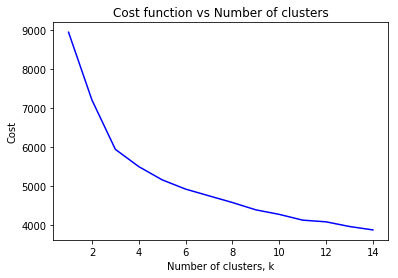

In [45]:
plt.plot(range(1,15), costs, 'b-')
plt.xlabel('Number of clusters, k')
plt.ylabel('Cost')
plt.title('Cost function vs Number of clusters')

We can see that the value of the cost function generally decreases as we increase the number of clusters, with diminishing returns as k gets very large. Usually, the choice of k depends on the underlying data and whether the clusters found make sense.

One way to define the 'elbow' of the graph is to draw a line from the first point to the last point and then find the point that is the furthest away from this line.

Text(0.5,1,'Cost function vs Number of clusters')

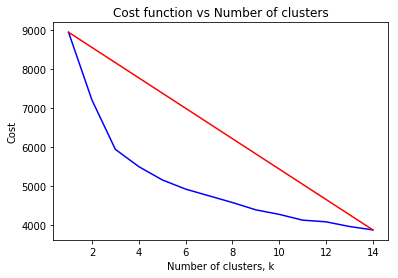

In [46]:
plt.plot(range(1,15), costs, 'b-')
plt.plot([range(1,15)[0], range(1,15)[-1]], [costs[0], costs[-1]], 'r-')
plt.xlabel('Number of clusters, k')
plt.ylabel('Cost')
plt.title('Cost function vs Number of clusters')

In [47]:
#code to calculate which point is furthest from the red line above
#taken from https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve
allCoord = np.vstack((range(1, 15), costs)).T
np.array([range(1,15), costs])
firstPoint = allCoord[0]
lineVec = allCoord[-1] - allCoord[0]
lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
vecFromFirst = allCoord - firstPoint
scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, 14, 1), axis=1)
vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
vecToLine = vecFromFirst - vecFromFirstParallel
distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
idxOfBestPoint = np.argmax(distToLine)
idxOfBestPoint

3

This indicates that k=4 (because our list of k values to test started at 1 in index 0) gives us the best trade-off between number of clusters and total cost. Let's see which players are in which cluster.

In [48]:
centroids, cluster_assignments = kmeans(scaled_data.as_matrix(), 4, 5000)
cost = compute_cost(scaled_data.as_matrix(), centroids)

#run kmeans 9 more times and keep the minimum cost result
for i in range(9):
    new_centroids, new_cluster_assignments = kmeans(scaled_data.as_matrix(), 4, 5000)
    new_cost = compute_cost(scaled_data.as_matrix(), new_centroids)
    if new_cost < cost:
        cost = new_cost
        centroids = new_centroids
        cluster_assignments = new_cluster_assignments

## 3. Visualising & Interpreting the Clusters <a class="anchor" id="third-bullet"></a>
Now that we have a set of clusters we want to take a look at what characterises each one.

In [49]:
per_min_stats['Cluster#'] = cluster_assignments
per_min_stats[['Player Name', 'Cluster#']].head()

,Player Name,Cluster#
0,Aaron Brooks,0
1,Aaron Gordon,3
2,Aaron Harrison,0
3,Abdel Nader,0
4,Adreian Payne,0


Text(0.5,1,'Count of players in each cluster, k=4')

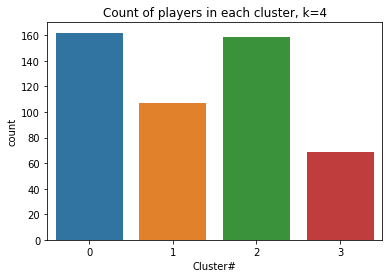

In [50]:
sns.countplot(per_min_stats['Cluster#'])
plt.title('Count of players in each cluster, k=4')

Clusters 0 and 2 are fairly equal in size, with a significant drop to Cluster 1 and Cluster 3. Let's take a look at the top few names in each.

In [51]:
for k in range(4):
    print('First 5 players in cluster ' + str(k))
    print(list(per_min_stats[per_min_stats['Cluster#'] == k]['Player Name'])[:5])

First 5 players in cluster 0
['Aaron Brooks', 'Aaron Harrison', 'Abdel Nader', 'Adreian Payne', 'Alex Abrines']
First 5 players in cluster 1
['Al Jefferson', 'Alan Williams', 'Alex Len', 'Amir Johnson', 'Andre Drummond']
First 5 players in cluster 2
['Al Horford', 'Al-Farouq Aminu', 'Alec Burks', 'Alec Peters', 'Allen Crabbe']
First 5 players in cluster 3
['Aaron Gordon', 'Anthony Davis', 'Ben Simmons', 'Blake Griffin', 'Bobby Portis']


It is difficult from this to see what the differences between the clusters are. We can calculate the mean for each statistic for each cluster in order to compare.

In [52]:
cluster_averages = per_min_stats.drop('Player Name',axis=1)
cluster_averages = cluster_averages.groupby(by='Cluster#').mean()
cluster_averages

,FGM,FGA,3PM,3PA,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,PF,PTS,+/-,Min,GP
Cluster#,,,,,,,,,,,,,,,,,,
0,0.105522,0.264132,0.034350,0.109326,0.036556,0.052965,0.030526,0.110783,0.141308,0.076208,0.044011,0.032561,0.014099,0.093660,0.281950,-0.084394,14.272145,37.956790
1,0.155075,0.294506,0.005683,0.023182,0.069974,0.103805,0.093642,0.202154,0.295796,0.056229,0.055314,0.027198,0.041429,0.117083,0.385806,-0.037328,16.636842,52.214953
2,0.157060,0.366146,0.060577,0.165272,0.056595,0.070651,0.022810,0.114128,0.136938,0.097349,0.051256,0.029580,0.012294,0.073463,0.431292,-0.013323,24.227029,63.069182
3,0.218087,0.474450,0.049932,0.139376,0.114571,0.143056,0.036205,0.147383,0.183588,0.141066,0.081341,0.037337,0.019641,0.075042,0.600677,0.019679,30.207824,61.434783


Some notes on the cluster averages:

**Cluster 0**
* Fewest average games played at 38.
* Only averaging 14 minutes per game. Likely to be players deeper in the rotation that aren't used as often.
* Lowest average of points and +/- per minute.

**Cluster 1**
* Averaging 52 games played.
* Significantly higher blocks & rebounds per minute.
* Likely to be back-up forwards/centers.

**Cluster 2**
* Averages 63 games played.
* Averaging 24 minutes per game.
* Highest 3PM and 3PA averages, tend to be more distance shooters.
* Likely to be back-up guards.

**Cluster 3**
* Averages 61 games played.
* Significantly higher minutes per game, +/- and points per minute than other groups.
* Attempt and make significantly more field-goals and free-throws than other groups.
* Smallest group, these are the most important players on each team.

Because we have many features, it is difficult to visualize the clusters. One method of dimensionality reduction is Principal Component Analysis (PCA).

The idea behind PCA is to find a set of new, orthogonal features that maximally explain the variance in our original features. By projecting our data onto the first 2 principal components we should be able to view the clusters in 2D.

I am using the scikit-learn implementation, but the maths can be found [here](https://plot.ly/ipython-notebooks/principal-component-analysis/). The process is as follows:
* Find the eigenvectors and eigenvalues of the covariance matrix.
* The eigenvectors are shape (p,1) where p is the number of features in the data.
* The eigenvectors represent linear combinations of the original features.
* Find the (in our case 2) eigenvectors that correspond to the largest eigenvalues.
* Project the data onto the eigenvectors, reducing the dimensionality from p to 2.

In [53]:
from sklearn.decomposition import PCA

#create a PCA object that is looking for the first 2 principal components
pca = PCA(n_components=2)

pca.fit(scaled_data.as_matrix())
reduced_data = pca.transform(scaled_data.as_matrix())

reduced_data.shape

(497, 2)

In [54]:
pca_plot_data = pd.DataFrame(reduced_data, columns = ['Component1','Component2'])
pca_plot_data['Cluster#'] = per_min_stats['Cluster#']
pca_plot_data['Player Name'] = per_min_stats['Player Name']
colormap = {0:'blue',1:'red',2:'green',3:'orange'}
pca_plot_data['Color'] = pca_plot_data['Cluster#'].map(colormap)
pca_plot_data['Legend'] = pca_plot_data['Cluster#'].apply(lambda x: 'Cluster ' + str(x))

pca_plot_data.sort_values(by='Cluster#', inplace=True)

source = ColumnDataSource(pca_plot_data)

p=figure(title='Principal Component Plot with k=4 Clusters',
        tools="pan,box_zoom,reset,save,hover")

hover = p.select(dict(type=HoverTool))

hover.tooltips = [('Component 1','@Component1'), ('Component 2','@Component2'), ('Name','@{Player Name}')]

p.circle('Component1', 'Component2', size=8, fill_color='Color',line_color='black',  
         source = source, alpha=0.8, legend='Legend')

p.legend

p.yaxis.axis_label = 'Principal Component 2'
p.xaxis.axis_label = 'Principal Component 1'
p.title.align = 'center'


show(p)

Now although we have no reference to the original statistics for each player we can see which players tend to be close to each other in this plane. Some notes:

* The 'superstar' players i.e. Lebron James, Stephen Curry, James Harden tend to be in Cluster 3 and located towards the bottom right of the plot. The top few players from each team tend to be in this cluster.
* Players towards the top of the plot tend to be in Cluster 1 and play the Center position (Dwight Howard, Rudy Gobert, DeAndre Jordan etc.).
* Players towards the bottom middle of the plot tend to be guards that shoot lots of 3 pointers (Kyle Korver, Wayne Ellington, Marco Belinelli. These players tend to be in Cluster 2.
* Players to the left tend to be in Cluster 3 and are players that play few minutes. A mixture of young players and veteran players that don't get many minutes and don't play very often.

The groups are fairly broad in nature because we have used a small number of clusters, however we can clearly see the differences between players in each cluster. Some small overlaps can be seen which is to be expected because we have projected to only 2 axes.

For reference, I have plotted the above visualisation for k=8 clusters below.

In [55]:
centroids, cluster_assignments = kmeans(scaled_data.as_matrix(), 8, 5000)
cost = compute_cost(scaled_data.as_matrix(), centroids)

#run kmeans 9 more times and keep the minimum cost result
for i in range(9):
    new_centroids, new_cluster_assignments = kmeans(scaled_data.as_matrix(), 8, 5000)
    new_cost = compute_cost(scaled_data.as_matrix(), new_centroids)
    if new_cost < cost:
        cost = new_cost
        centroids = new_centroids
        cluster_assignments = new_cluster_assignments

In [56]:
from bokeh.palettes import Category20_8

pca_plot_data = pd.DataFrame(reduced_data, columns = ['Component1','Component2'])
pca_plot_data['Cluster#'] = cluster_assignments
pca_plot_data['Player Name'] = per_min_stats['Player Name']
pca_plot_data['Color'] = pca_plot_data['Cluster#'].apply(lambda x: Category20_8[x])
pca_plot_data['Legend'] = pca_plot_data['Cluster#'].apply(lambda x: 'Cluster ' + str(x))

pca_plot_data.sort_values(by='Cluster#', inplace=True)

source = ColumnDataSource(pca_plot_data)

p=figure(title='Principal Component Plot with k=8 Clusters',
        tools="pan,box_zoom,reset,save,hover")

hover = p.select(dict(type=HoverTool))

hover.tooltips = [('Component 1','@Component1'), ('Component 2','@Component2'), ('Name','@{Player Name}')]

p.circle('Component1', 'Component2', size=8, fill_color='Color',line_color='black',  
         source = source, alpha=0.8, legend='Legend')

p.legend

p.yaxis.axis_label = 'Principal Component 2'
p.xaxis.axis_label = 'Principal Component 1'
p.title.align = 'center'


show(p)

We can see that although in our original feature space this set of clusters has a lower total cost, it is much more difficult to visualise and interpret.

## 4. Conclusions & Improvements <a class="anchor" id="fourth-bullet"></a>

In summary we have:
* Explored the distribution of various per-game and per-minute statistics of NBA players that played more than 5 games in the 2017/2018 regular season.
* Written a k-means clustering algorithm that minimizes the Euclidean distance between data points and cluster centers, using smart cluster initialisation to avoid getting stuck on local minima.
* Identified that k=4 is a reasonable number of clusters to group the NBA players, based on the diminishing cost benefit of further increasing the k value.
* Identified the characteristics that separate the clusters at a high level by comparing the average statistics over each cluster.
* Used Principal Component Analysis to plot the data on a 2D plane and visualize the clusters. This helped to look at which players are in which cluster and how close within each cluster certain players are.

The main improvements that I can think of for this model are as follows:
* Including non-game statistics, such as player age, height, weight, nationality, salary.
* Including salary would actually be very interesting from the perspective of a coach looking to sign new players. They could identify players that are 'high value' in the sense of the impact they have on the game as a function of how much of the teams salary cap space they take up.

Thanks for reading!